In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL

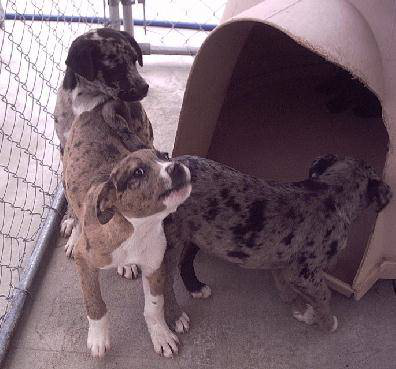

In [106]:
PATH = 'data/cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Explore data
train_dir = pathlib.Path(train_dir)
dogs_train = list(train_dir.glob('dogs/*'))
PIL.Image.open(str(dogs_train[1]))

In [107]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size, 
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size, 
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size, 
    directory=PATH,
    classes=['test'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


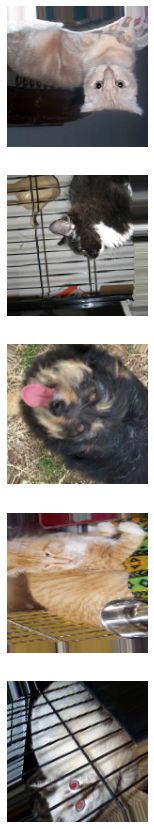

In [108]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

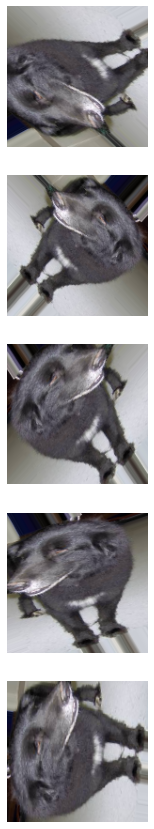

In [23]:
# Plot the same image to see transformations
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [109]:
# Create model and compile
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                5308480   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [114]:
# Train model on train dataset and validate with validation dataset
steps_per_epoch = int(np.ceil(total_train / batch_size))
validation_steps = int(np.ceil(total_val / batch_size))

history = model.fit(train_data_gen, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs,
                    validation_data=val_data_gen, 
                    validation_steps=validation_steps)

Epoch 1/15
16/16 [==============================] - 32s 2s/step - loss: 0.7701 - accuracy: 0.4970 - val_loss: 0.6888 - val_accuracy: 0.5770
Epoch 2/15
16/16 [==============================] - 37s 2s/step - loss: 0.6828 - accuracy: 0.5635 - val_loss: 0.6594 - val_accuracy: 0.5700
Epoch 3/15
16/16 [==============================] - 37s 2s/step - loss: 0.6698 - accuracy: 0.5660 - val_loss: 0.6560 - val_accuracy: 0.5550
Epoch 4/15
16/16 [==============================] - 35s 2s/step - loss: 0.6585 - accuracy: 0.5815 - val_loss: 0.6322 - val_accuracy: 0.6420
Epoch 5/15
16/16 [==============================] - 37s 2s/step - loss: 0.6450 - accuracy: 0.6195 - val_loss: 0.6832 - val_accuracy: 0.5380
Epoch 6/15
16/16 [==============================] - 35s 2s/step - loss: 0.6390 - accuracy: 0.6370 - val_loss: 0.6237 - val_accuracy: 0.6270
Epoch 7/15
16/16 [==============================] - 32s 2s/step - loss: 0.6220 - accuracy: 0.6545 - val_loss: 0.6067 - val_accuracy: 0.6590
Epoch 8/15
16/16 [==

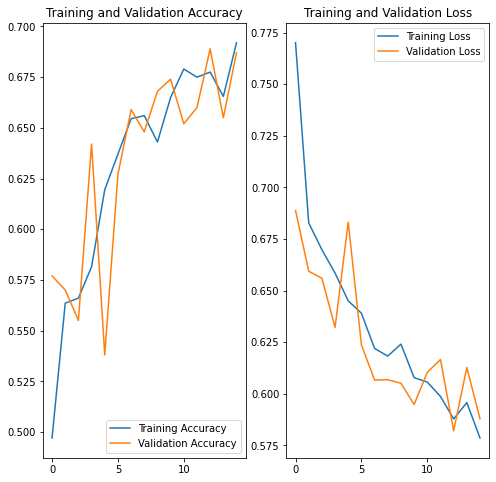

In [120]:
# Plot loss and acc curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()